In [78]:
import pickle

with open('results/p_values_regions_greater_FDR_v4.pkl', 'rb') as f:
    p_values_greater_fdr = pickle.load(f)


In [79]:
import pickle

with open('results/p_values_regions_less_FDR_v4.pkl', 'rb') as f:
    p_values_less_fdr = pickle.load(f)


In [80]:
import numpy as np

def marcar_clusters_significativos(pvals, alpha=0.05, min_cluster_size=6):
    pvals = np.array(pvals)
    significativos = pvals < alpha
    resultado = np.ones_like(pvals)

    # Buscar clústeres contiguos
    start = 0
    while start < len(significativos):
        if significativos[start]:
            end = start
            while end < len(significativos) and significativos[end]:
                end += 1
            if end - start >= min_cluster_size:
                resultado[start:end] = pvals[start:end]
            start = end
        else:
            start += 1

    return resultado.tolist()


In [81]:
greater_clusters = {}
less_clusters = {}

for electrodo in p_values_greater_fdr:
    greater_clusters[electrodo] = {}
    less_clusters[electrodo] = {}

    for comparacion in p_values_greater_fdr[electrodo]:
        p_greater = p_values_greater_fdr[electrodo][comparacion]
        p_less = p_values_less_fdr[electrodo][comparacion]

        # Aplicar clústeres
        greater_clusters[electrodo][comparacion] = marcar_clusters_significativos(p_greater)
        less_clusters[electrodo][comparacion] = marcar_clusters_significativos(p_less)

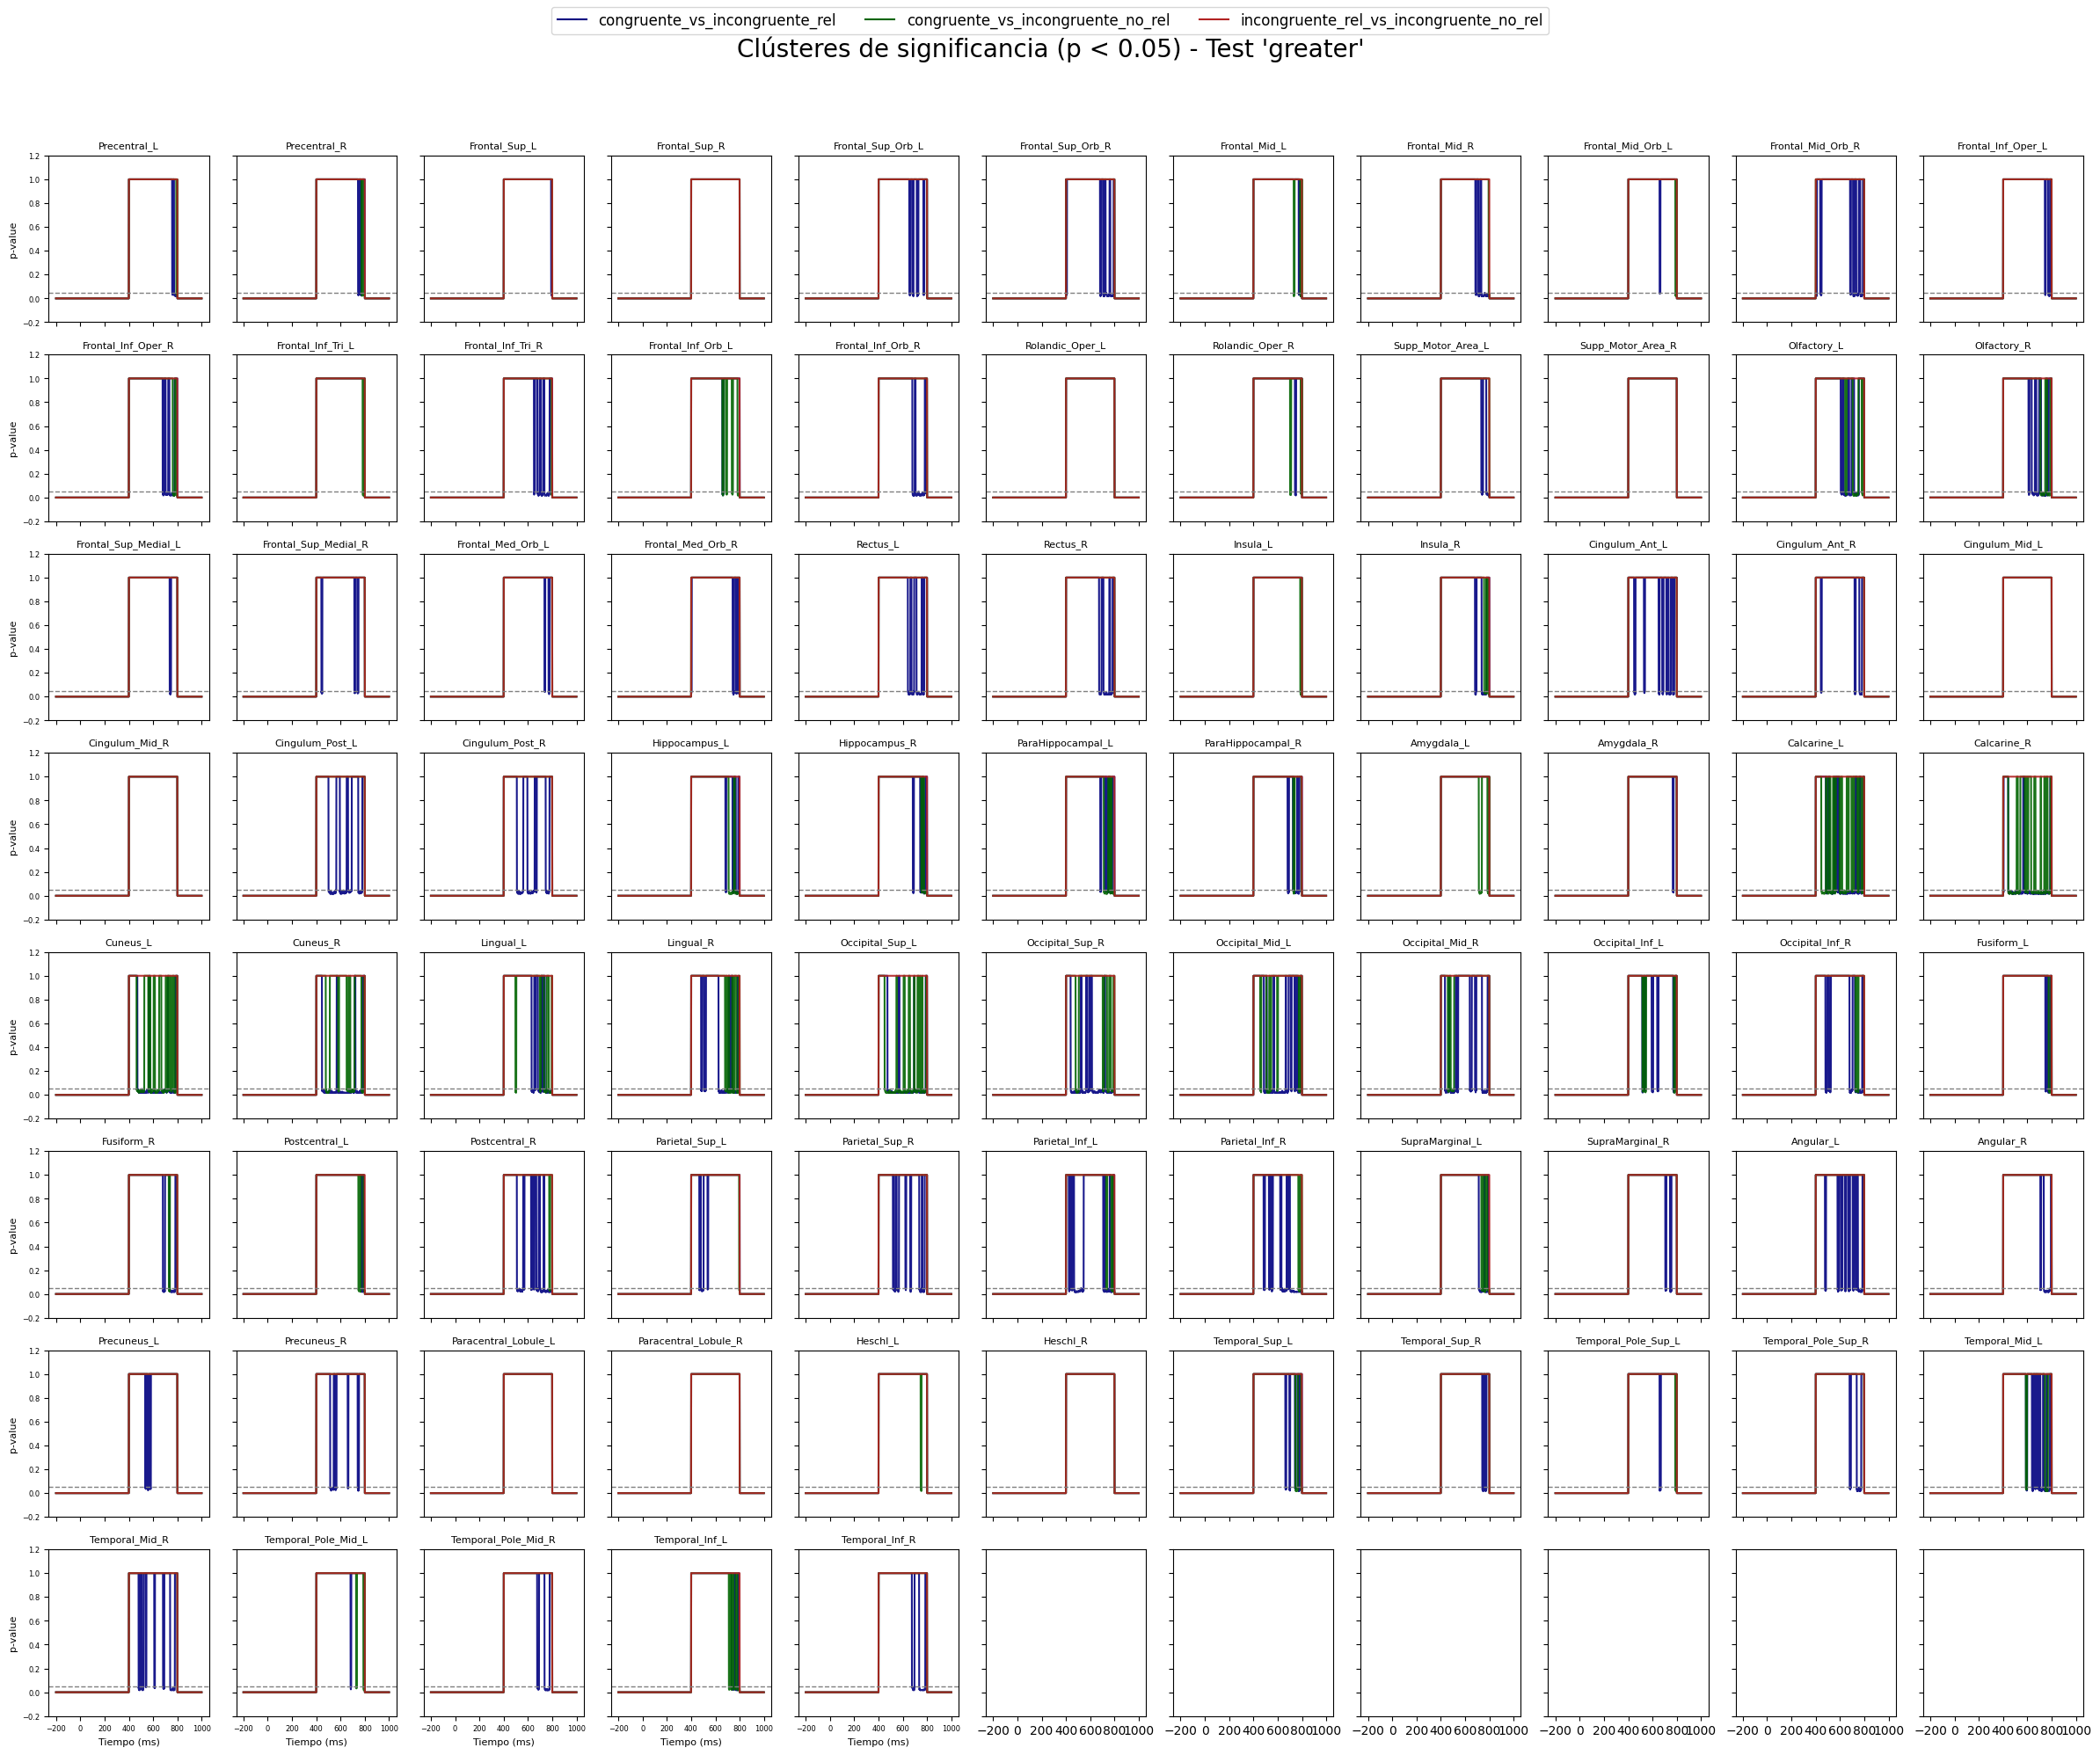

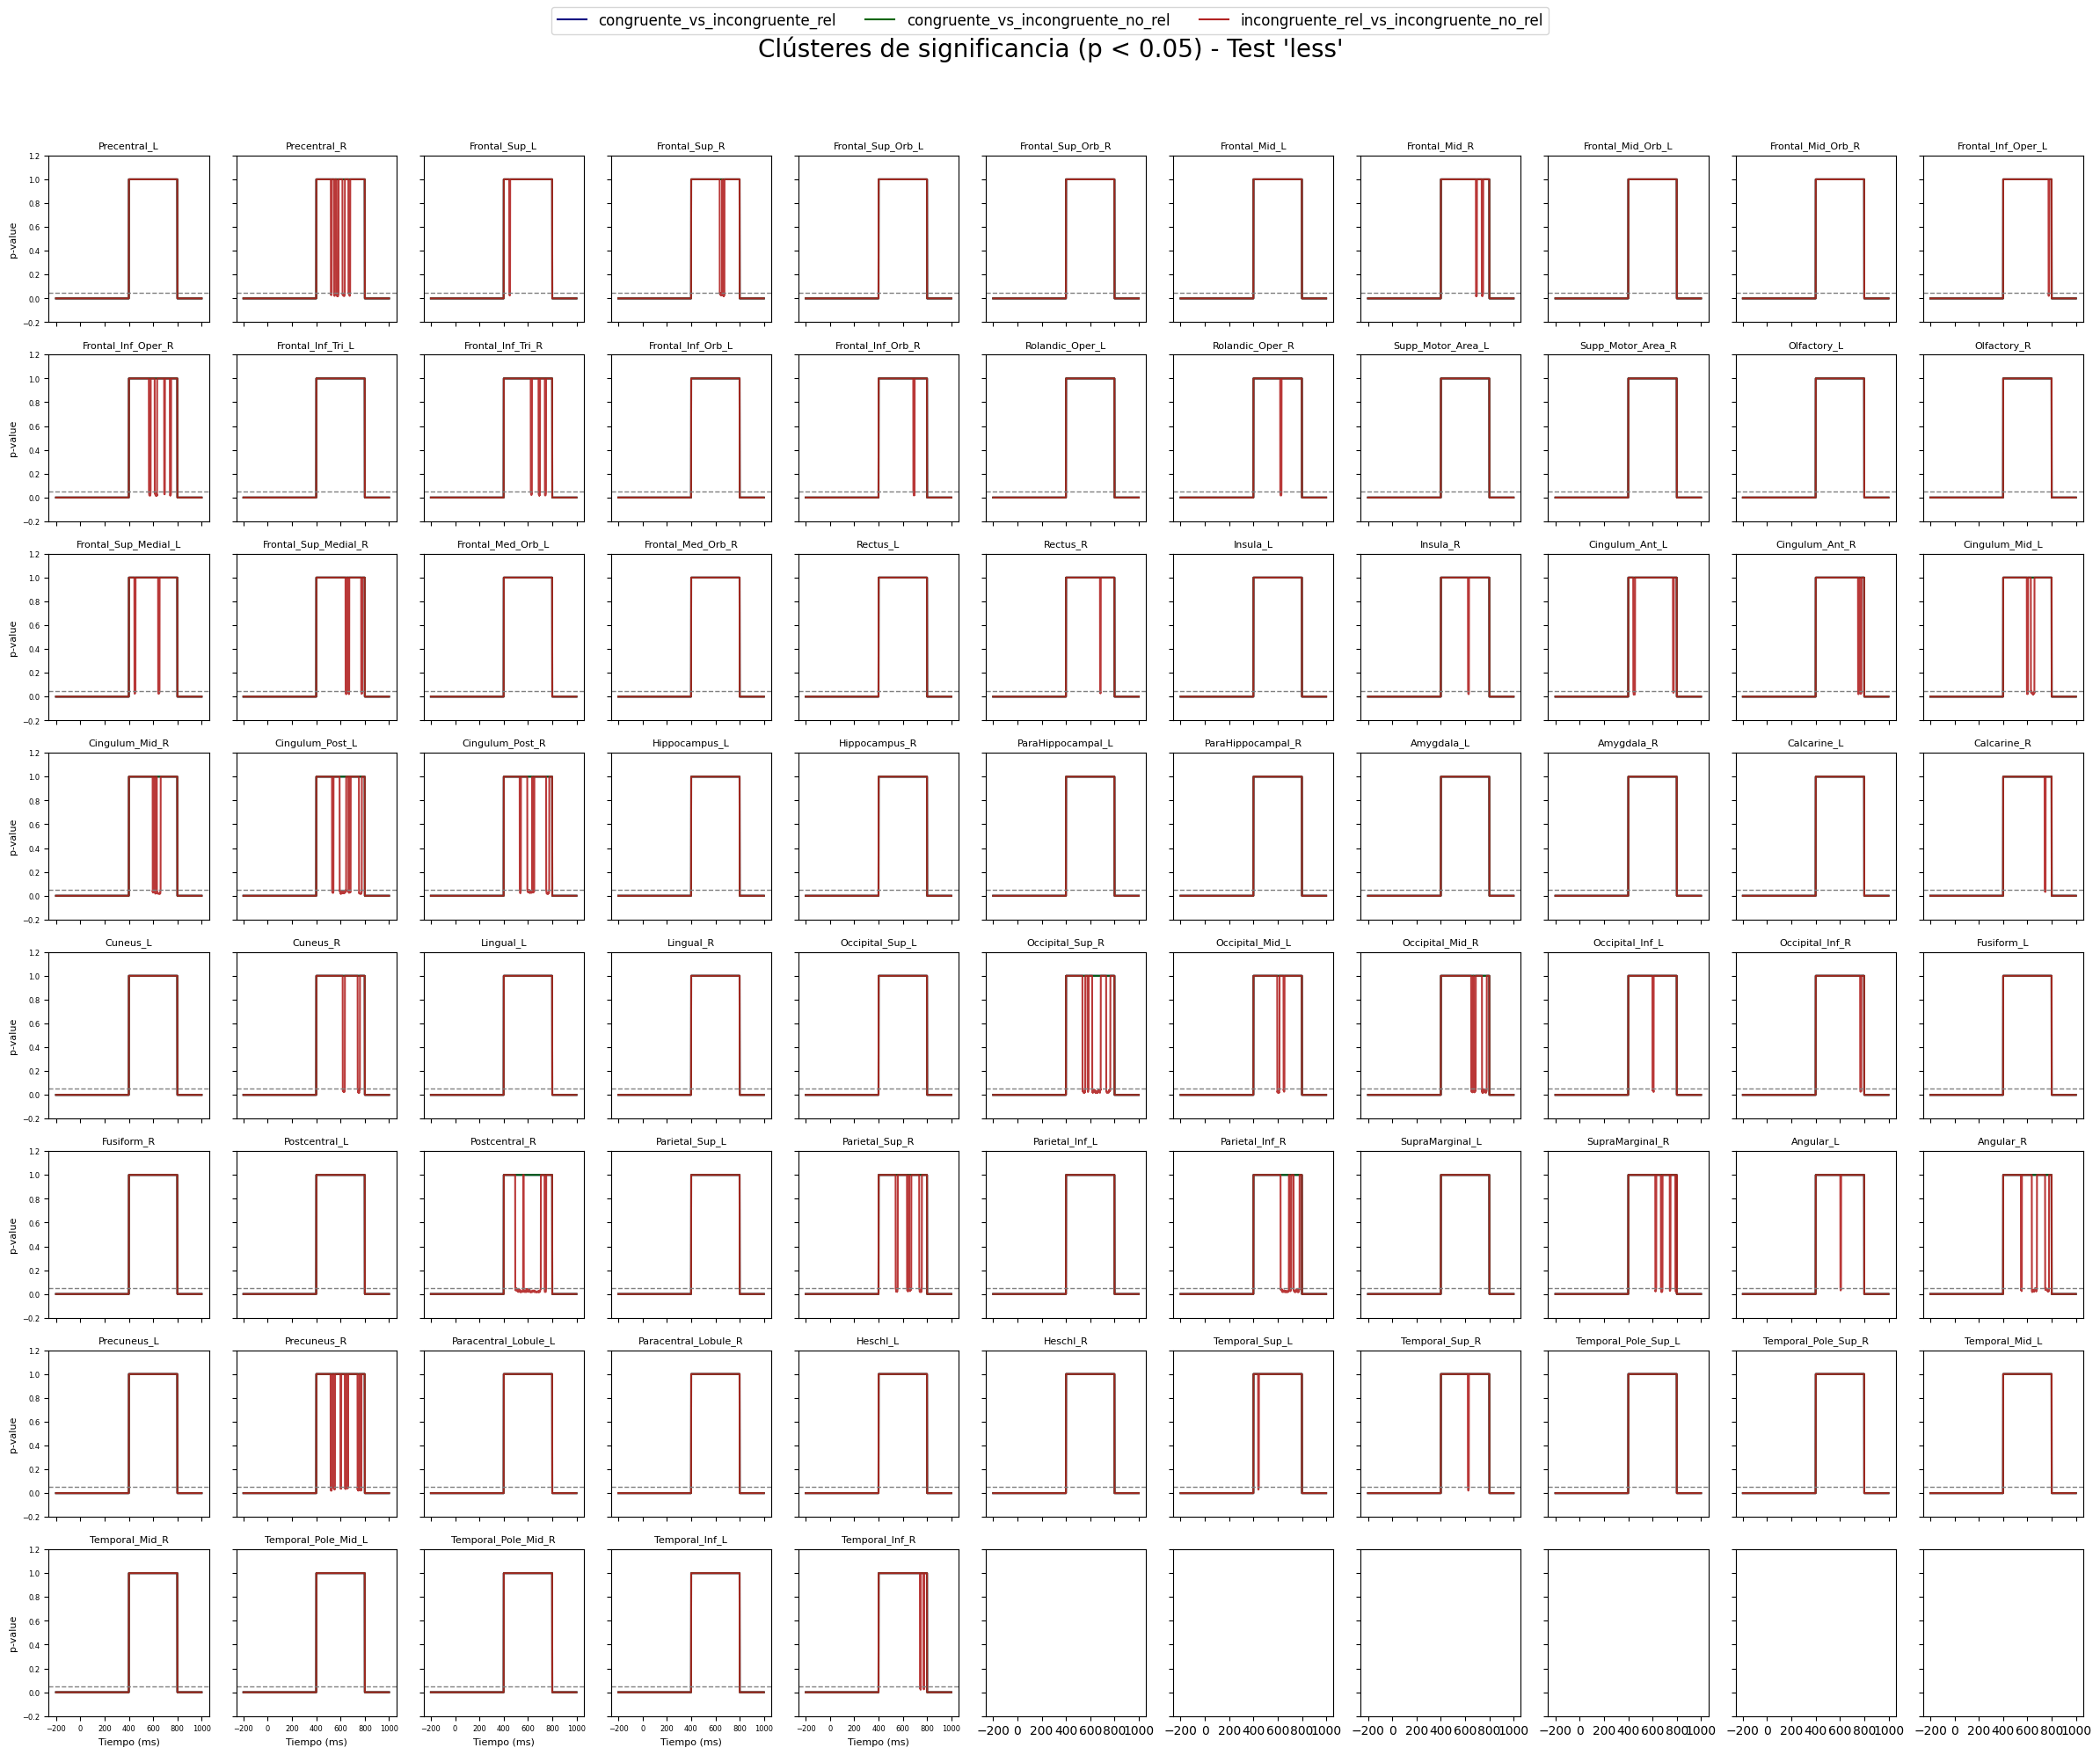

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Paleta de colores para comparaciones
comparisons_colors = {
    'congruente_vs_incongruente_rel': 'navy',
    'congruente_vs_incongruente_no_rel': 'darkgreen',
    'incongruente_rel_vs_incongruente_no_rel': 'firebrick'
}

# Frecuencia de muestreo y eje temporal
fs = 1024  # Hz
pre_stim_ms = -200
n_muestras = len(next(iter(greater_clusters.values()))['congruente_vs_incongruente_rel'])
tiempos_ms = np.arange(n_muestras) * (1000 / fs) + pre_stim_ms

# Layout 8x8 para 64 electrodos
rows, cols = 8, 11

# Crear carpeta para figuras si no existe
os.makedirs("figuras", exist_ok=True)

# Función general para graficar
def plot_clusters(p_values_clusters, title, filename):
    fig, axes = plt.subplots(rows, cols, figsize=(24, 20), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=20)

    for idx, (electrode, comps) in enumerate(p_values_clusters.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        for comparison, pvals in comps.items():
            color = comparisons_colors.get(comparison, 'black')
            ax.plot(tiempos_ms, pvals, label=comparison, color=color, alpha=0.9)

        ax.axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
        ax.set_title(electrode, fontsize=8)
        ax.set_ylim(-0.2, 1.2)
        ax.tick_params(labelsize=6)

        if row == rows - 1:
            ax.set_xlabel("Tiempo (ms)", fontsize=8)
        if col == 0:
            ax.set_ylabel("p-value", fontsize=8)

    # Leyenda global
    handles = [plt.Line2D([0], [0], color=c, label=comp) for comp, c in comparisons_colors.items()]
    fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.savefig(f"figuras/{filename}.pdf", format='pdf')
    # fig.savefig(f"figuras/{filename}.svg", format='svg')
    plt.show()

# Graficar clusters greater
plot_clusters(
    greater_clusters,
    title="Clústeres de significancia (p < 0.05) - Test 'greater'",
    filename="clusters_significativos_greater"
)

# Graficar clusters less
plot_clusters(
    less_clusters,
    title="Clústeres de significancia (p < 0.05) - Test 'less'",
    filename="clusters_significativos_less"
)


In [83]:
def binarizar_clusters(clusters_dict):
    resultado = {}
    for electrodo in clusters_dict:
        resultado[electrodo] = {}
        for comparacion in clusters_dict[electrodo]:
            valores = np.array(clusters_dict[electrodo][comparacion])
            binario = (valores != 1.0).astype(int)
            resultado[electrodo][comparacion] = binario.tolist()
    return resultado


In [84]:
clusters_binarios_less = binarizar_clusters(less_clusters)
clusters_binarios_greater = binarizar_clusters(greater_clusters)


In [85]:
ch_names = list (greater_clusters.keys() )

In [86]:
with open('../ROIS_Felipe.txt', 'r') as Rois:
    Rois_lista = [int(line.strip()) for line in Rois]


# GREATER

In [87]:
import numpy as np
import os

# Parámetros de las ventanas
fs = 1024  # frecuencia de muestreo
offset = 205  # para compensar pre-estímulo

inicio_total = 400      # en ms
fin_total = 800         # en ms
tamano_ventana = 25     # ms
solapamiento = 12.5     # ms
umbral_proporcion = 0.5

# Generar ventanas en milisegundos
inicios = np.arange(inicio_total, fin_total - tamano_ventana + solapamiento, solapamiento)
ventanas_ms = [(round(start, 1), round(start + tamano_ventana, 1)) for start in inicios]
ventanas_samples = [(int(start / 1000 * fs) + offset, int(end / 1000 * fs) + offset) for start, end in ventanas_ms]

# Comparaciones a graficar
comparaciones = ['congruente_vs_incongruente_rel',
                 'congruente_vs_incongruente_no_rel',
                 'incongruente_rel_vs_incongruente_no_rel']

# Títulos opcionales
titulos = {
    'congruente_vs_incongruente_rel': 'Congruent vs Related Incongruent',
    'congruente_vs_incongruente_no_rel': 'Congruent vs Unrelated Incongruent',
    'incongruente_rel_vs_incongruente_no_rel': 'Related Incongruent vs Unrelated Incongruent'
}

# Crear carpeta de salida si no existe
os.makedirs("voxel_Loreta", exist_ok=True)

# Inicializar diccionario para guardar las matrices de significancia
matrices_significancia = {comp: [] for comp in comparaciones}


# Resultados
for comp in comparaciones:
    for idx_ventana, (start_sample, end_sample) in enumerate(ventanas_samples):
        eeg_data_binaria = np.zeros(82)

        # Evaluar cada ROI
        for i, region in enumerate(ch_names[:82]):  # asegurando solo 82 regiones
            if region in clusters_binarios_greater and comp in clusters_binarios_greater[region]:
                datos_region = clusters_binarios_greater[region][comp][start_sample:end_sample]
                proporcion_activa = np.mean(datos_region)
                if proporcion_activa >= umbral_proporcion:
                    eeg_data_binaria[i] = 1

         # Guardar fila binaria de esta ventana
        matrices_significancia[comp].append(eeg_data_binaria.copy())


        # Mostrar regiones activadas
        regiones_activadas = [ch_names[i] for i, v in enumerate(eeg_data_binaria) if v == 1]
        print(f"Regiones activadas - {titulos[comp]} ({ventanas_ms[idx_ventana][0]}-{ventanas_ms[idx_ventana][1]} ms):")
        for r in regiones_activadas:
            print(f"  - {r}")
        print("-" * 60)

        # Mapear a voxeles
        data_voxeles = [int(eeg_data_binaria[region - 1]) for region in Rois_lista]  # Rois_lista es de 1 a 82
        eeg_voxeles_export = data_voxeles

        # Guardar a archivo
        # filename = f"voxel_Loreta/voxeles_{comp}_{int(ventanas_ms[idx_ventana][0])}-{int(ventanas_ms[idx_ventana][1])}ms.txt"
        # with open(filename, 'w') as f:
        #     for valor in eeg_voxeles_export:
        #         f.write(f"{valor}\n")


Regiones activadas - Congruent vs Related Incongruent (400.0-425.0 ms):
------------------------------------------------------------
Regiones activadas - Congruent vs Related Incongruent (412.5-437.5 ms):
------------------------------------------------------------
Regiones activadas - Congruent vs Related Incongruent (425.0-450.0 ms):
  - Occipital_Mid_R
  - Parietal_Inf_L
------------------------------------------------------------
Regiones activadas - Congruent vs Related Incongruent (437.5-462.5 ms):
  - Calcarine_R
  - Cuneus_R
  - Occipital_Sup_R
  - Occipital_Mid_R
------------------------------------------------------------
Regiones activadas - Congruent vs Related Incongruent (450.0-475.0 ms):
  - Calcarine_R
  - Cuneus_R
  - Occipital_Sup_R
  - Occipital_Mid_R
------------------------------------------------------------
Regiones activadas - Congruent vs Related Incongruent (462.5-487.5 ms):
  - Calcarine_R
  - Cuneus_L
  - Cuneus_R
  - Occipital_Sup_L
  - Occipital_Sup_R
  - 

In [88]:
import pandas as pd
# Convertir las matrices a dataframes
df_matrices = {}
for comp in comparaciones:
    matriz = np.array(matrices_significancia[comp])
    df = pd.DataFrame(matriz, columns=ch_names[:82])
    df.index.name = "ventana"
    df_matrices[comp] = df

In [89]:
df_matrices['congruente_vs_incongruente_rel']

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Temporal_Sup_L,Temporal_Sup_R,Temporal_Pole_Sup_L,Temporal_Pole_Sup_R,Temporal_Mid_L,Temporal_Mid_R,Temporal_Pole_Mid_L,Temporal_Pole_Mid_R,Temporal_Inf_L,Temporal_Inf_R
ventana,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


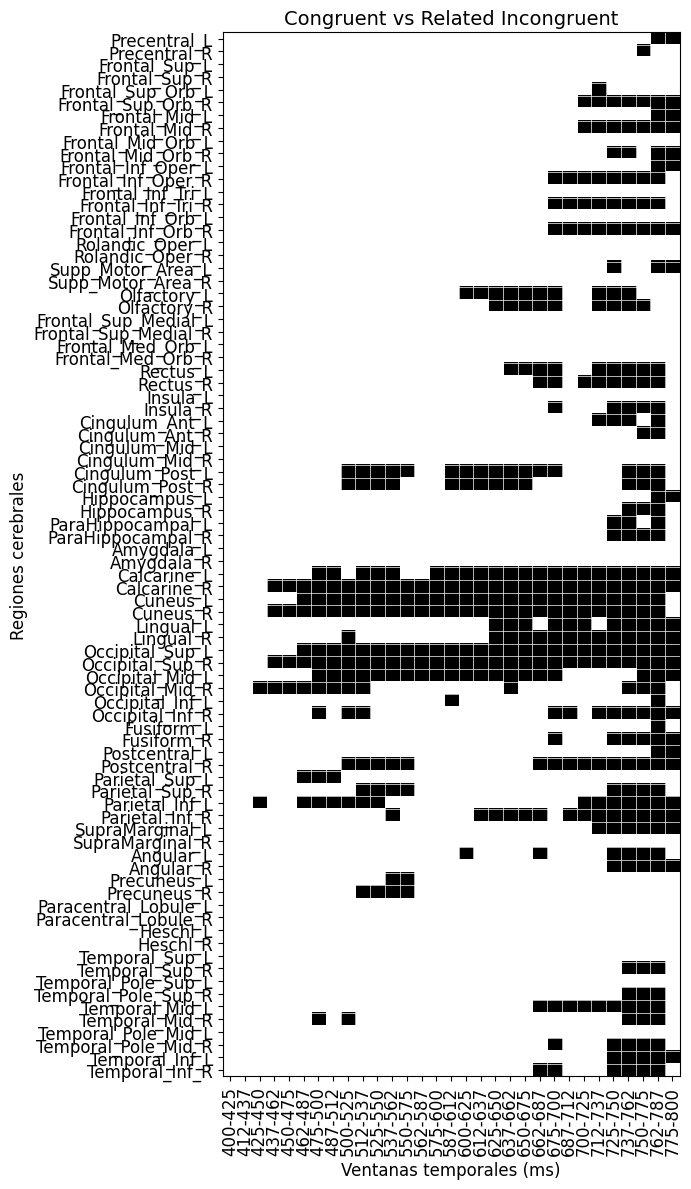

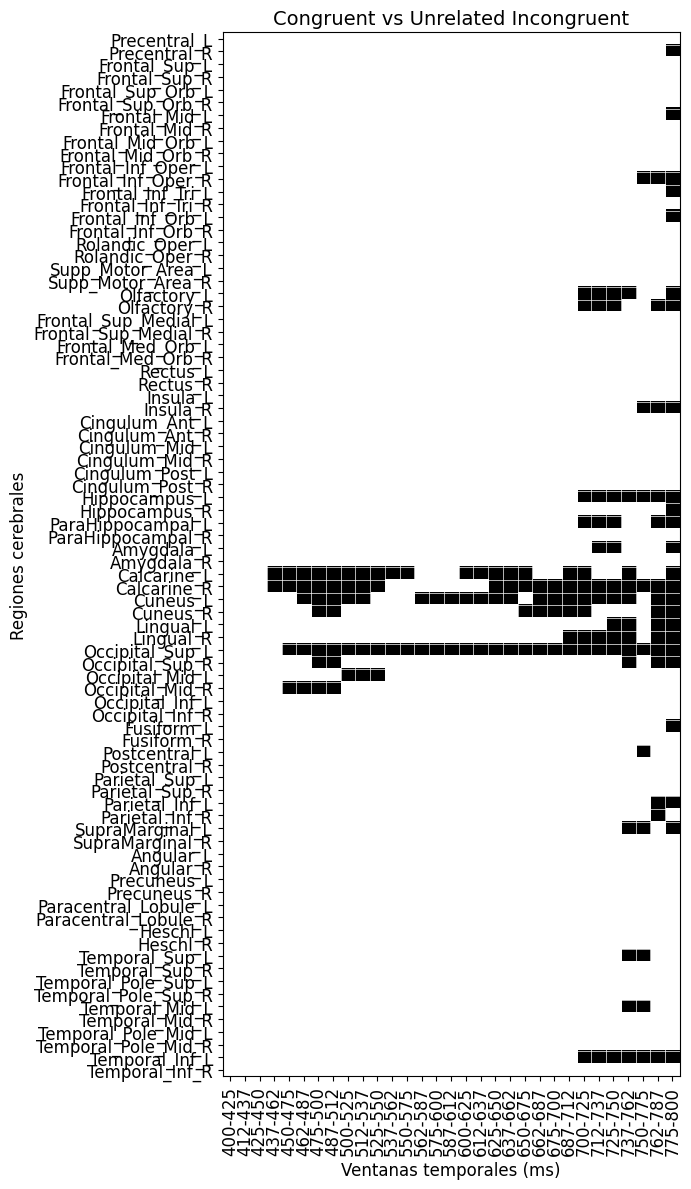

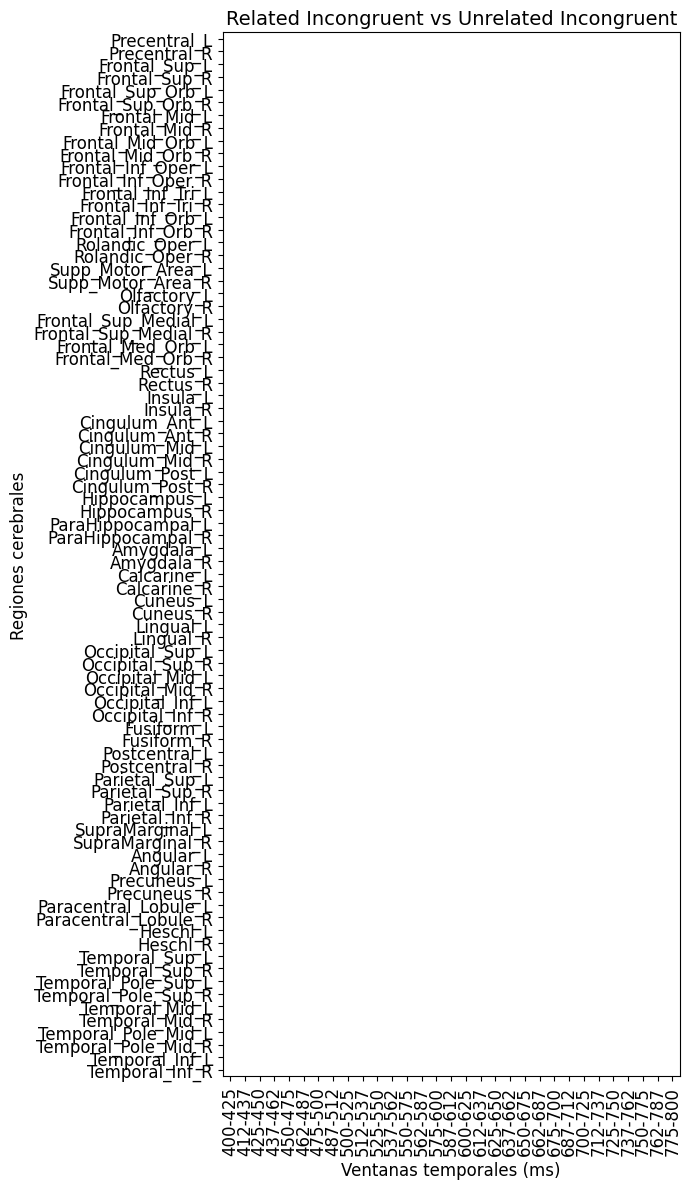

In [90]:
import matplotlib.pyplot as plt

for comp in comparaciones:
    df = df_matrices[comp].T  # Transponer: regiones en eje Y
    fig, ax = plt.subplots(figsize=(7, 12))

    # Mostrar matriz
    cax = ax.imshow(df.values, cmap='gray_r', aspect='auto', interpolation='none')

    # Agregar líneas blancas para bordes de celdas
    ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas y formato
    ax.set_title(titulos[comp], fontsize=14)
    ax.set_ylabel("Regiones cerebrales", fontsize=12)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=12)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels([f"{int(start)}-{int(end)}" for start, end in ventanas_ms],
                       rotation=90, fontsize=12)
    ax.set_xlabel("Ventanas temporales (ms)", fontsize=12)

    plt.tight_layout()
    plt.show()


In [91]:
import pandas as pd
import numpy as np

def filtro_ventanas_consecutivas(df, min_consecutivas=4):
    df_filtrado = df.copy()

    for col in df.columns:
        arr = df[col].values
        # Detectar corridas consecutivas de 1
        max_run = 0
        current_run = 0
        run_indices = []

        # Guardar las posiciones de la corrida más larga (solo si es >= min_consecutivas)
        best_start = None
        best_end = None

        for i, val in enumerate(arr):
            if val == 1:
                current_run += 1
                if current_run >= min_consecutivas and (best_start is None or current_run > max_run):
                    max_run = current_run
                    best_end = i
                    best_start = i - current_run + 1
            else:
                current_run = 0

        # Si no hay corrida suficientemente larga, poner todo 0 en esa columna
        if max_run < min_consecutivas:
            df_filtrado[col] = 0
        else:
            # Poner a cero las ventanas que no formen parte de la corrida más larga válida
            new_col = np.zeros_like(arr)
            new_col[best_start:best_end + 1] = 1
            df_filtrado[col] = new_col

    return df_filtrado

# Aplicar a todos los DataFrames del diccionario
df_matrices_filtradas = {}
for comp, df in df_matrices.items():
    df_matrices_filtradas[comp] = filtro_ventanas_consecutivas(df, min_consecutivas=4)


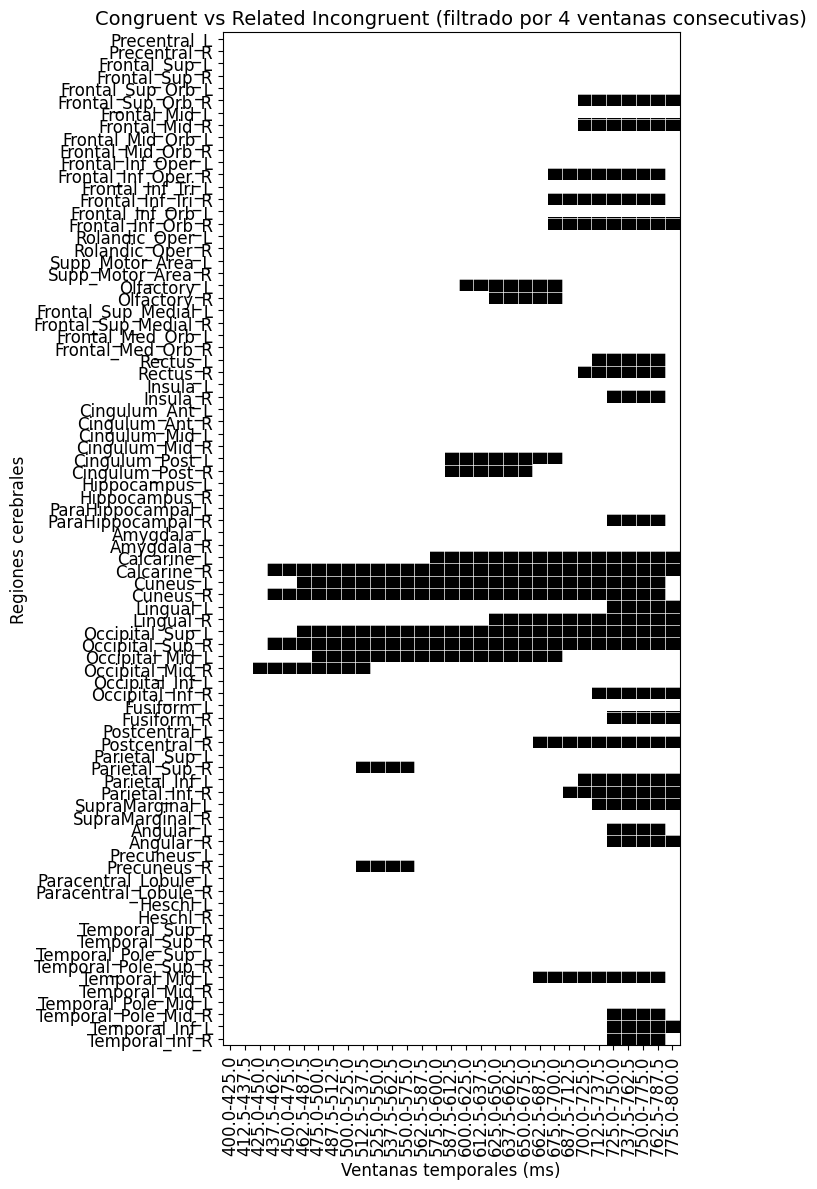

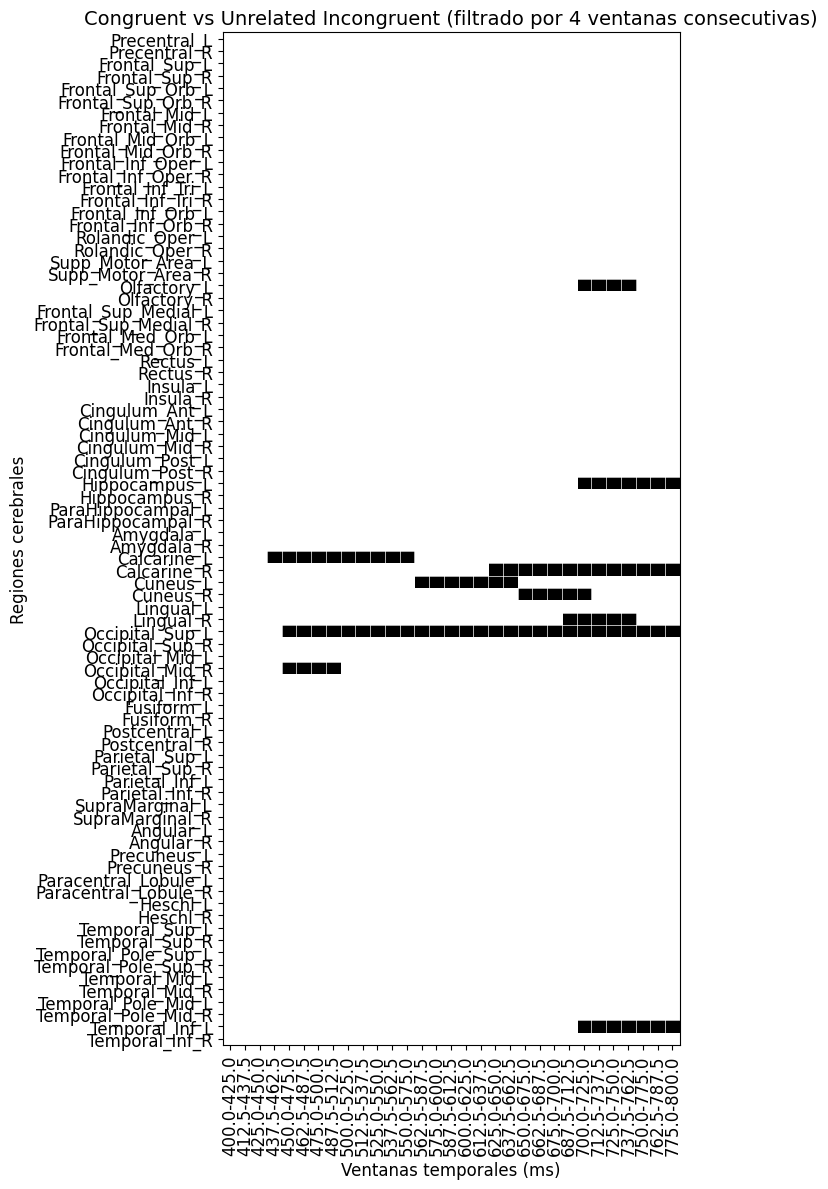

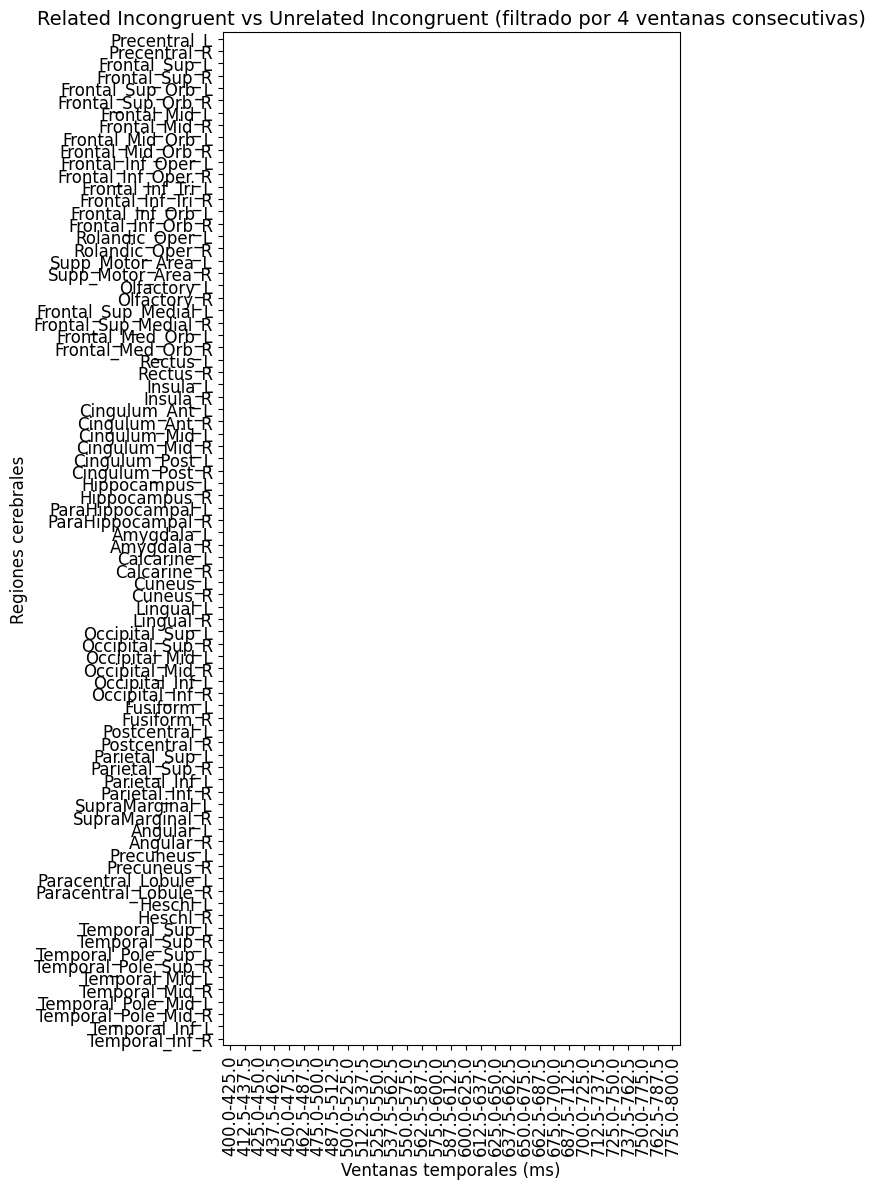

In [92]:
import matplotlib.pyplot as plt
import numpy as np

for comp in comparaciones:
    df = df_matrices_filtradas[comp].T  # Transponer para regiones en eje Y
    fig, ax = plt.subplots(figsize=(7, 12))

    # Mostrar matriz filtrada
    cax = ax.imshow(df.values, cmap='gray_r', aspect='auto', interpolation='none')

    # Líneas blancas para bordes de celdas
    ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas y formato
    ax.set_title(titulos[comp] + " (filtrado por 4 ventanas consecutivas)", fontsize=14)
    ax.set_ylabel("Regiones cerebrales", fontsize=12)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=12)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels([f"{start:.1f}-{end:.1f}" for start, end in ventanas_ms],
                   rotation=90, fontsize=12)
    ax.set_xlabel("Ventanas temporales (ms)", fontsize=12)

    plt.tight_layout()
    plt.show()


Advertencia: incongruente_rel_vs_incongruente_no_rel no tiene regiones con diferencias.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3520\1068680312.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


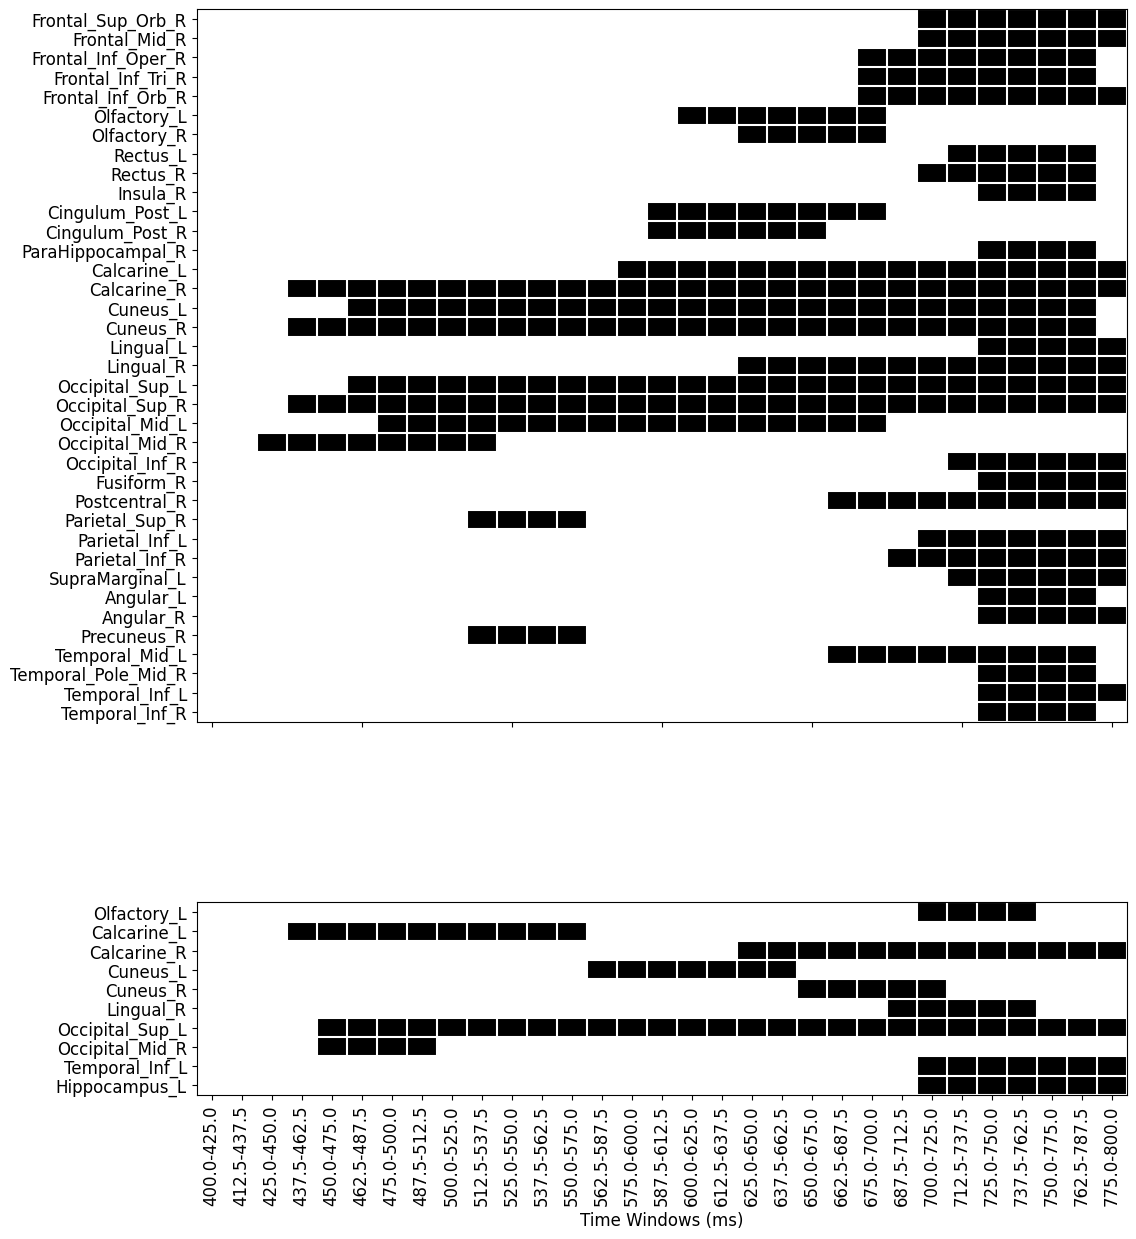

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from matplotlib.gridspec import GridSpec

# Orden maestro de regiones
all_regions = []
for comp in comparaciones:
    df = df_matrices_filtradas[comp].T
    filtered_regions = df.loc[~(df == 0).all(axis=1)].index.tolist()
    for r in filtered_regions:
        if r not in all_regions:
            all_regions.append(r)

# Filtrar y guardar dfs filtrados
filtered_dfs = {}
for comp in comparaciones:
    df = df_matrices_filtradas[comp].T
    filtered = df.loc[~(df == 0).all(axis=1)]
    if filtered.empty:
        print(f"Advertencia: {comp} no tiene regiones con diferencias.")
        continue
    filtered = filtered.reindex([r for r in all_regions if r in filtered.index])
    filtered_dfs[comp] = filtered

n_plots = len(filtered_dfs)
rows_per_plot = [len(df) for df in filtered_dfs.values()]

# Para que no haya subplots con altura 0 (por si alguna tiene 0 regiones)
rows_per_plot = [max(1, r) for r in rows_per_plot]

total_rows = sum(rows_per_plot)
fig_height = max(3, 0.3 * total_rows)
fig_width = 12

fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(n_plots, 1, height_ratios=rows_per_plot, figure=fig, hspace=0.4)

axes = []
for i in range(n_plots):
    ax = fig.add_subplot(gs[i, 0])
    axes.append(ax)

for ax, (comp, filtered) in zip(axes, filtered_dfs.items()):
    cax = ax.imshow(filtered.values, cmap='gray_r', aspect='auto', interpolation='none')

    # Líneas blancas para bordes de celdas
    ax.set_xticks(np.arange(-0.5, len(filtered.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(filtered.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas eje Y
    ax.set_yticks(np.arange(len(filtered.index)))
    ax.set_yticklabels(filtered.index, fontsize=12)

    # Sólo la última gráfica tendrá etiquetas en eje X
    if ax == axes[-1]:
        ax.set_xticks(np.arange(len(filtered.columns)))
        ax.set_xticklabels(
            [f"{start:.1f}-{end:.1f}" for start, end in ventanas_ms],
            rotation=90, fontsize=12
        )
        ax.set_xlabel("Time Windows (ms)", fontsize=12)
    else:
        ax.set_xticklabels([])

    ax.set_ylabel("", fontsize=12, labelpad=5)

    title = textwrap.fill( " ", width=40)
    ax.set_title(title, fontsize=14)

plt.tight_layout()
fig.savefig(f"figuras/Diferencias_Ventanas_Comparacion_ajustada.pdf", format='pdf')
fig.savefig(f"figuras/Diferencias_Ventanas_Comparacion_ajustada.svg", format='svg')

plt.show()


In [ ]:
df_matrices_filtradas

{'congruente_vs_incongruente_rel':          Precentral_L  Precentral_R  Frontal_Sup_L  Frontal_Sup_R  \
 ventana                                                             
 0                   0             0              0              0   
 1                   0             0              0              0   
 2                   0             0              0              0   
 3                   0             0              0              0   
 4                   0             0              0              0   
 5                   0             0              0              0   
 6                   0             0              0              0   
 7                   0             0              0              0   
 8                   0             0              0              0   
 9                   0             0              0              0   
 10                  0             0              0              0   
 11                  0             0              0     

In [95]:
import pandas as pd

# Diccionario para guardar los promedios por condición
promedios_por_condicion = {}

for condicion, df in df_matrices_filtradas.items():
    # Calcula la media por electrodo (columnas)
    promedio = df.sum(axis=0)
    promedios_por_condicion[condicion] = promedio

# Si quieres convertir a DataFrame final: filas = condiciones, columnas = electrodos
df_promedios = pd.DataFrame(promedios_por_condicion).T


In [96]:
lobulos = {
    "Lóbulo Frontal": [
        "Precentral_L", "Precentral_R",
        "Frontal_Sup_L", "Frontal_Sup_R",
        "Frontal_Sup_Orb_L", "Frontal_Sup_Orb_R",
        "Frontal_Mid_L", "Frontal_Mid_R",
        "Frontal_Mid_Orb_L", "Frontal_Mid_Orb_R",
        "Frontal_Inf_Oper_L", "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_L", "Frontal_Inf_Orb_R",
        "Rolandic_Oper_L", "Rolandic_Oper_R",
        "Supp_Motor_Area_L", "Supp_Motor_Area_R",
        "Olfactory_L", "Olfactory_R",
        "Frontal_Sup_Medial_L", "Frontal_Sup_Medial_R",
        "Frontal_Med_Orb_L", "Frontal_Med_Orb_R",
        "Rectus_L", "Rectus_R"
    ],
    "Sistema Límbico": [
        "Insula_L", "Insula_R",
        "Cingulum_Ant_L", "Cingulum_Ant_R",
        "Cingulum_Mid_L", "Cingulum_Mid_R",
        "Cingulum_Post_L", "Cingulum_Post_R",
        "Hippocampus_L", "Hippocampus_R",
        "ParaHippocampal_L", "ParaHippocampal_R",
        "Amygdala_L", "Amygdala_R"
    ],
    "Lóbulo Occipital": [
        "Calcarine_L", "Calcarine_R",
        "Cuneus_L", "Cuneus_R",
        "Lingual_L", "Lingual_R",
        "Occipital_Sup_L", "Occipital_Sup_R",
        "Occipital_Mid_L", "Occipital_Mid_R",
        "Occipital_Inf_L", "Occipital_Inf_R",
        "Fusiform_L", "Fusiform_R",
        "Postcentral_L", "Postcentral_R"
    ],
    "Lóbulo Parietal": [
        "Parietal_Sup_L", "Parietal_Sup_R",
        "Parietal_Inf_L", "Parietal_Inf_R",
        "SupraMarginal_L", "SupraMarginal_R",
        "Angular_L", "Angular_R",
        "Precuneus_L", "Precuneus_R",
        "Paracentral_Lobule_L", "Paracentral_Lobule_R"
    ],
    "Lóbulo Temporal": [
        "Heschl_L", "Heschl_R",
        "Temporal_Sup_L", "Temporal_Sup_R",
        "Temporal_Pole_Sup_L", "Temporal_Pole_Sup_R",
        "Temporal_Mid_L", "Temporal_Mid_R",
        "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R",
        "Temporal_Inf_L", "Temporal_Inf_R"
    ]
}


Paleta de colores

In [143]:
df_regiones_cerebrales = pd.read_excel('AAL90_coloreado_por_lobulo_tableau.xlsx')

In [110]:
AAL_mapping_final = pd.read_excel('AAL_Mapping.xlsx')

Advertencia: incongruente_rel_vs_incongruente_no_rel no tiene regiones con diferencias.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3520\3139698548.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


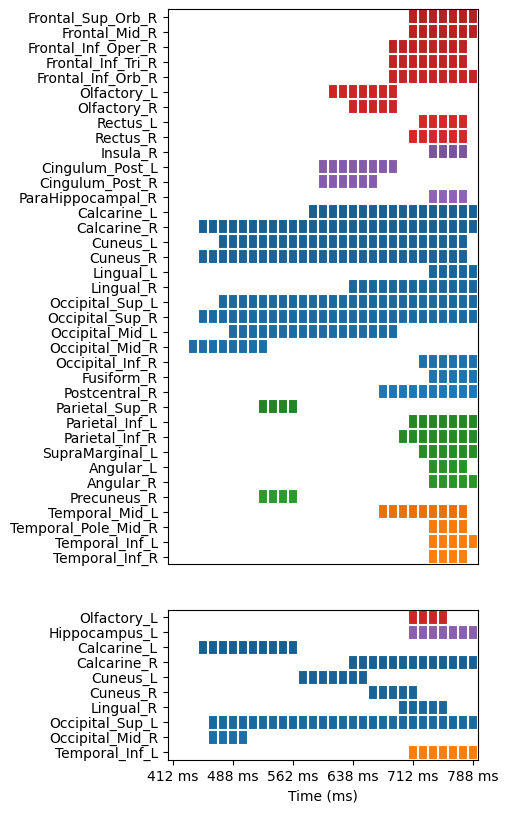

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import textwrap

# Parámetros tamaño fijo por celda (en pulgadas)
cell_height = 0.15
cell_width = 0.1

# ---------- ORDEN FIJO ----------
# lobulos dict y ordered_regions (debes definir lobulos antes)
ordered_regions = [r for regiones in lobulos.values() for r in regiones]

# ---------- COLORES POR REGIÓN ----------
color_dict = dict(zip(df_regiones_cerebrales['AAL90_Region'], df_regiones_cerebrales['Color_HEX']))
default_color = "#888888"

# ---------- REGIONES PRESENTES ----------
regiones_presentes = set()
for comp in comparaciones:
    df = df_matrices_filtradas[comp].T
    presentes = df.loc[~(df == 0).all(axis=1)].index.tolist()
    regiones_presentes.update(presentes)

# Orden final respetando orden de lobulos
all_regions = [r for r in ordered_regions if r in regiones_presentes]

# ---------- FILTRAR Y GUARDAR ----------
filtered_dfs = {}
for comp in comparaciones:
    df = df_matrices_filtradas[comp].T
    filtered = df.loc[~(df == 0).all(axis=1)]
    if filtered.empty:
        print(f"Advertencia: {comp} no tiene regiones con diferencias.")
        continue
    filtered = filtered.reindex([r for r in all_regions if r in filtered.index])
    filtered_dfs[comp] = filtered

n_plots = len(filtered_dfs)
rows_per_plot = [len(df) for df in filtered_dfs.values()]
rows_per_plot = [max(1, r) for r in rows_per_plot]
max_cols = max(df.shape[1] for df in filtered_dfs.values())

# Calcular tamaño total de figura
fig_width = cell_width * max_cols + 2  # + margen
fig_height = cell_height * sum(rows_per_plot) + 2  # + margen

fig = plt.figure(figsize=(fig_width, fig_height))

# Posiciones de subplots (left, bottom, width, height) en fracciones de la figura [0,1]
bottom_start = 1 - 1/fig_height
current_bottom = 1 - 1/fig_height - 0.05

axes = []
for i, (comp, filtered) in enumerate(filtered_dfs.items()):
    n_rows = rows_per_plot[i]
    height = (cell_height * n_rows) / fig_height
    width = (cell_width * max_cols) / fig_width
    left = 0.1  # margen izquierdo fijo
    bottom = current_bottom - height

    ax = fig.add_axes([left, bottom, width, height])
    axes.append((ax, comp, filtered))
    current_bottom = bottom - 0.05  # espacio entre subplots

for ax, comp, filtered in axes:
    n_rows, n_cols = filtered.shape

    # Crear imagen RGB con colores por región
    image_rgb = np.ones((n_rows, n_cols, 3))  # fondo blanco
    for i, region in enumerate(filtered.index):
        hex_color = color_dict.get(region, default_color)
        rgb = mcolors.to_rgb(hex_color)
        for j in range(n_cols):
            if filtered.iloc[i, j] == 1:
                image_rgb[i, j, :] = rgb

    ax.imshow(image_rgb, aspect='auto', interpolation='none')

    # Grid
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas Y
    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(filtered.index, fontsize=10)

    # Etiquetas X solo para la última gráfica
    if ax == axes[-1][0]:

        # Calcular los promedios de cada ventana
        promedios_ventanas = [(start + end) / 2 for start, end in ventanas_ms]

        # Seleccionar 6 posiciones equidistantes del total
        n_ticks = 6
        tick_indices = np.linspace(0, len(promedios_ventanas) - 1, n_ticks, dtype=int)

        # Aplicar los ticks al eje X
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(
            [f"{promedios_ventanas[i]:.0f} ms" for i in tick_indices],
            rotation=0, fontsize=10
        )

        ax.set_xlabel("Time (ms)", fontsize=10)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    ax.set_title("")

plt.tight_layout()
fig.savefig("figuras/Diferencias_Ventanas_Comparacion_1.pdf", format='pdf')
fig.savefig("figuras/Diferencias_Ventanas_Comparacion_1.svg", format='svg')
plt.show()


In [141]:
df_matrices_filtradas

{'congruente_vs_incongruente_rel':          Precentral_L  Precentral_R  Frontal_Sup_L  Frontal_Sup_R  \
 ventana                                                             
 0                   0             0              0              0   
 1                   0             0              0              0   
 2                   0             0              0              0   
 3                   0             0              0              0   
 4                   0             0              0              0   
 5                   0             0              0              0   
 6                   0             0              0              0   
 7                   0             0              0              0   
 8                   0             0              0              0   
 9                   0             0              0              0   
 10                  0             0              0              0   
 11                  0             0              0     

In [142]:
regiones_presentes = {}

for nombre_comparacion, df in df_matrices_filtradas.items():
    # Sumar por columna → si hay algún 1, la suma será > 0
    suma_columnas = df.sum(axis=0)
    
    # Filtrar regiones con al menos una aparición (suma > 0)
    regiones = suma_columnas[suma_columnas > 0].index.tolist()
    
    # Guardar en el diccionario
    regiones_presentes[nombre_comparacion] = regiones

# Imprimir resultados
for comparacion, regiones in regiones_presentes.items():
    print(f"\n🧠 Regiones presentes en '{comparacion}':")
    print(regiones)



🧠 Regiones presentes en 'congruente_vs_incongruente_rel':
['Frontal_Sup_Orb_R', 'Frontal_Mid_R', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_R', 'Olfactory_L', 'Olfactory_R', 'Rectus_L', 'Rectus_R', 'Insula_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'ParaHippocampal_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_R', 'Fusiform_R', 'Postcentral_R', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'Angular_L', 'Angular_R', 'Precuneus_R', 'Temporal_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R']

🧠 Regiones presentes en 'congruente_vs_incongruente_no_rel':
['Olfactory_L', 'Hippocampus_L', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Mid_R', 'Temporal_Inf_L']

🧠 Regiones presentes en 'incongruente_rel_vs_incongruente_no_rel':
[]


In [111]:
# Supongamos que ya tienes:
# - `AAL_mapping_final` con columnas: AAL3_Index, AAL3_Region, AAL90_Index, AAL90_Region
# - `promedios_por_condicion` es tu diccionario de resultados

# Preparamos un mapeo inverso de AAL90_Region → AAL3 (puede haber múltiples AAL3 por AAL90)
from collections import defaultdict

aal90_to_aal3 = defaultdict(list)
for _, row in AAL_mapping_final.dropna().iterrows():
    aal90_to_aal3[row['AAL90_Region']].append((int(row['AAL3_Index']), row['AAL3_Region']))

# Diccionario para guardar resultados
resultados_aal3 = {}

# Procesamos cada comparación
for nombre_comparacion, serie in promedios_por_condicion.items():
    regiones_significativas = serie[serie > 0].index  # regiones AAL90 con valor > 0

    indices_aal3 = []
    nombres_aal3 = []

    for region in regiones_significativas:
        if region in aal90_to_aal3:
            lista_aal3 = aal90_to_aal3[region]
            for idx, nombre in lista_aal3:
                indices_aal3.append(idx)
                nombres_aal3.append(nombre)

    resultados_aal3[nombre_comparacion] = {
        'indices': indices_aal3,
        'nombres': nombres_aal3
    }

# Ejemplo: ver los resultados para una comparación
print("Comparación: congruente_vs_incongruente_rel")
print("Índices AAL3:", resultados_aal3['congruente_vs_incongruente_rel']['indices'])
print("Nombres AAL3:", resultados_aal3['congruente_vs_incongruente_rel']['nombres'])


Comparación: congruente_vs_incongruente_rel
Índices AAL3: [7, 9, 11, 13, 18, 19, 24, 25, 35, 38, 39, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 61, 63, 64, 65, 66, 68, 69, 71, 86, 89, 90, 91]
Nombres AAL3: ['Frontal_Mid_2_R', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_R', 'Olfactory_L', 'Olfactory_R', 'Rectus_L', 'Rectus_R', 'Insula_R', 'Cingulate_Post_L', 'Cingulate_Post_R', 'ParaHippocampal_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_R', 'Fusiform_R', 'Postcentral_R', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'Angular_L', 'Angular_R', 'Precuneus_R', 'Temporal_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R']


In [112]:
from collections import defaultdict

# Creamos diccionario de salida
lobulos_aal3 = defaultdict(lambda: {"indices": [], "nombres": []})

# Recorremos cada lóbulo y su lista de regiones AAL90
for lobulo, regiones_aal90 in lobulos.items():
    for region in regiones_aal90:
        # Filtramos en el mapping las regiones AAL3 que mapean a esta AAL90
        matches = AAL_mapping_final[AAL_mapping_final['AAL90_Region'] == region]
        for _, row in matches.iterrows():
            lobulos_aal3[lobulo]["indices"].append(int(row['AAL3_Index']))
            lobulos_aal3[lobulo]["nombres"].append(row['AAL3_Region'])

# Convertimos a dict normal (opcional)
lobulos_aal3 = dict(lobulos_aal3)

# Ejemplo: ver el lóbulo temporal
# print("Lóbulo Temporal (AAL3):")
# print("Índices:", lobulos_aal3["Lóbulo Temporal"]["indices"])
# print("Nombres:", lobulos_aal3["Lóbulo Temporal"]["nombres"])


In [113]:
for comparacion, datos in resultados_aal3.items():
    print(f"\n=== Comparación: {comparacion} ===")

    indices_significativos = set(datos['indices'])  # Para búsqueda rápida

    for lobulo, contenido in lobulos_aal3.items():
        indices_lobulo = contenido['indices']
        nombres_lobulo = contenido['nombres']

        regiones_en_lobulo = [
            (idx, nombre) for idx, nombre in zip(indices_lobulo, nombres_lobulo)
            if idx in indices_significativos
        ]

        if regiones_en_lobulo:
            print(f"\nLóbulo: {lobulo}")
            for idx, nombre in regiones_en_lobulo:
                print(f"  - {idx}: {nombre}")



=== Comparación: congruente_vs_incongruente_rel ===

Lóbulo: Lóbulo Frontal
  - 7: Frontal_Mid_2_R
  - 9: Frontal_Inf_Oper_R
  - 11: Frontal_Inf_Tri_R
  - 13: Frontal_Inf_Orb_2_R
  - 18: Olfactory_L
  - 19: Olfactory_R
  - 24: Rectus_L
  - 25: Rectus_R

Lóbulo: Sistema Límbico
  - 35: Insula_R
  - 38: Cingulate_Post_L
  - 39: Cingulate_Post_R
  - 43: ParaHippocampal_R

Lóbulo: Lóbulo Occipital
  - 46: Calcarine_L
  - 47: Calcarine_R
  - 48: Cuneus_L
  - 49: Cuneus_R
  - 50: Lingual_L
  - 51: Lingual_R
  - 52: Occipital_Sup_L
  - 53: Occipital_Sup_R
  - 54: Occipital_Mid_L
  - 55: Occipital_Mid_R
  - 57: Occipital_Inf_R
  - 59: Fusiform_R
  - 61: Postcentral_R

Lóbulo: Lóbulo Parietal
  - 63: Parietal_Sup_R
  - 64: Parietal_Inf_L
  - 65: Parietal_Inf_R
  - 66: SupraMarginal_L
  - 68: Angular_L
  - 69: Angular_R
  - 71: Precuneus_R

Lóbulo: Lóbulo Temporal
  - 86: Temporal_Mid_L
  - 89: Temporal_Pole_Mid_R
  - 90: Temporal_Inf_L
  - 91: Temporal_Inf_R

=== Comparación: congruente_vs_inc

In [114]:
resultados_por_lobulo = {}

for comparacion, datos in resultados_aal3.items():
    indices_significativos = set(datos['indices'])
    resultados_por_lobulo[comparacion] = {}

    for lobulo, contenido in lobulos_aal3.items():
        indices_lobulo = contenido['indices']
        nombres_lobulo = contenido['nombres']

        regiones_en_lobulo = [
            (idx, nombre) for idx, nombre in zip(indices_lobulo, nombres_lobulo)
            if idx in indices_significativos
        ]

        if regiones_en_lobulo:
            indices = [idx for idx, _ in regiones_en_lobulo]
            nombres = [nombre for _, nombre in regiones_en_lobulo]
            resultados_por_lobulo[comparacion][lobulo] = {
                'indices': indices,
                'nombres': nombres
            }

# Imprimir listas en formato compacto y legible
for comparacion, lobulos_dict in resultados_por_lobulo.items():
    print(f"\n# --- Comparación: {comparacion} ---")
    for lobulo, listas in lobulos_dict.items():
        print(f"{lobulo}:")
        print(f"  indices = {listas['indices']}")
        print(f"  nombres = {listas['nombres']}")



# --- Comparación: congruente_vs_incongruente_rel ---
Lóbulo Frontal:
  indices = [7, 9, 11, 13, 18, 19, 24, 25]
  nombres = ['Frontal_Mid_2_R', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_R', 'Olfactory_L', 'Olfactory_R', 'Rectus_L', 'Rectus_R']
Sistema Límbico:
  indices = [35, 38, 39, 43]
  nombres = ['Insula_R', 'Cingulate_Post_L', 'Cingulate_Post_R', 'ParaHippocampal_R']
Lóbulo Occipital:
  indices = [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 61]
  nombres = ['Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_R', 'Fusiform_R', 'Postcentral_R']
Lóbulo Parietal:
  indices = [63, 64, 65, 66, 68, 69, 71]
  nombres = ['Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'Angular_L', 'Angular_R', 'Precuneus_R']
Lóbulo Temporal:
  indices = [86, 89, 90, 91]
  nombres = ['Temporal_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L

In [140]:
df_regiones_cerebrales

,Unnamed: 0,AAL3_Index,AAL3_Region,AAL90_Index,AAL90_Region,Lobulo,Color_RGB,Color_HEX
0,1,2,Precentral_L,1.0,Precentral_L,Lobulo Frontal,"0.218,0.000,0.000",#380000
1,2,3,Precentral_R,2.0,Precentral_R,Lobulo Frontal,"0.230,0.000,0.000",#3b0000
2,3,4,Frontal_Sup_2_L,3.0,Frontal_Sup_L,Lobulo Frontal,"0.242,0.000,0.000",#3e0000
3,4,5,Frontal_Sup_2_R,4.0,Frontal_Sup_R,Lobulo Frontal,"0.254,0.000,0.000",#410000
4,5,6,Frontal_Mid_2_L,7.0,Frontal_Mid_L,Lobulo Frontal,"0.291,0.000,0.000",#4a0000
...,...,...,...,...,...,...,...,...
161,162,163,Red_N_R,NaN,nan,NaN,NaN,NaN
162,163,164,LC_L,NaN,nan,NaN,NaN,NaN
163,164,165,LC_R,NaN,nan,NaN,NaN,NaN
164,165,166,Raphe_D,NaN,nan,NaN,NaN,NaN


In [137]:
resultados_aal3

{'congruente_vs_incongruente_rel': {'indices': [7,
   9,
   11,
   13,
   18,
   19,
   24,
   25,
   35,
   38,
   39,
   43,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   57,
   59,
   61,
   63,
   64,
   65,
   66,
   68,
   69,
   71,
   86,
   89,
   90,
   91],
  'nombres': ['Frontal_Mid_2_R',
   'Frontal_Inf_Oper_R',
   'Frontal_Inf_Tri_R',
   'Frontal_Inf_Orb_2_R',
   'Olfactory_L',
   'Olfactory_R',
   'Rectus_L',
   'Rectus_R',
   'Insula_R',
   'Cingulate_Post_L',
   'Cingulate_Post_R',
   'ParaHippocampal_R',
   'Calcarine_L',
   'Calcarine_R',
   'Cuneus_L',
   'Cuneus_R',
   'Lingual_L',
   'Lingual_R',
   'Occipital_Sup_L',
   'Occipital_Sup_R',
   'Occipital_Mid_L',
   'Occipital_Mid_R',
   'Occipital_Inf_R',
   'Fusiform_R',
   'Postcentral_R',
   'Parietal_Sup_R',
   'Parietal_Inf_L',
   'Parietal_Inf_R',
   'SupraMarginal_L',
   'Angular_L',
   'Angular_R',
   'Precuneus_R',
   'Temporal_Mid_L',
   'Temporal_Pole_Mid_R',
   'Temporal_Inf_L

# Less

In [ ]:
df_rege